# PPO

### Setup

In [175]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.wrappers import TransformObservation
from itertools import chain

In [134]:
def pytorch_env(env):
    env = TransformObservation(env, lambda x: torch.from_numpy(x).float(), env.observation_space)
    return env

In [465]:
env = pytorch_env(gym.make('HalfCheetah-v5'))

In [135]:
def update_plot(data, title="", xlabel="", ylabel="", grid=True, sleep=0.01):
    clear_output(wait=True)
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid)
    plt.show()
    time.sleep(sleep)

In [466]:
N_OBSERVATIONS = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]

TEST = False
TRAIN = True
SAVE = False

### Hyperparameters

In [467]:
# Hyperparameters
n_agents = 4
n_timesteps = 128
gamma = 0.99
epsilon = 0.2
v = 1.0 # Value constant
learning_rate = 3e-4
batch_size = 64
n_epochs = 10
n_trainsteps = 20
max_grad_norm = 0.5
layer_dim = 64
std = 1.

### Model

In [445]:
class Actor(nn.Module):
	def __init__(self, n_observations, n_actions, layer_dim, std):
		super().__init__()
		self.n_actions = n_actions
		self.mu_network = nn.Sequential(
			nn.Linear(n_observations, layer_dim),
			nn.LayerNorm(layer_dim),
			nn.Tanh(),
			nn.Linear(layer_dim, layer_dim),
			nn.LayerNorm(layer_dim),
			nn.Tanh(),
			nn.Linear(layer_dim, n_actions)
		)
		self.std = std

	def forward(self, obs):
		means = self.mu_network(obs)
		return means
	
	def distribution_list(self, state_batch):
		distribution_list = []
		for state in state_batch:
			means = self.forward(state)
			cov_matrix = torch.eye(self.n_actions) * (self.std ** 2)
			distribution = torch.distributions.MultivariateNormal(means, cov_matrix)
			distribution_list.append(distribution)
		return distribution_list

	def select_action(self, state):
		with torch.no_grad():
			means = self.forward(state)
		cov_matrix = torch.eye(self.n_actions) * (self.std ** 2)
		action_distribution = torch.distributions.MultivariateNormal(means, cov_matrix)
		action = action_distribution.sample()
		return action

In [446]:
class Critic(nn.Module):
	def __init__(self, n_observations, layer_dim):
		super().__init__()
		self.v_network = nn.Sequential(
			nn.Linear(n_observations, layer_dim),
			nn.LayerNorm(layer_dim),
			nn.Tanh(),
			nn.Linear(layer_dim, layer_dim),
			nn.LayerNorm(layer_dim),
			nn.Tanh(),
			nn.Linear(layer_dim, 1)
		)

	def forward(self, obs):
		value = self.v_network(obs)
		return value

### Test model

In [433]:
def test_model(actor, env):
	episode_reward = 0.
	state, _ = env.reset()
	terminated, truncated = False, False
	while not (terminated or truncated):
		action = actor.select_action(state)
		state, reward, terminated, truncated, _ = env.step(action.numpy())
		episode_reward += reward
	env.close()
	return episode_reward

### PPO Dataset

In [470]:
class PPODataset(Dataset):
	def __init__(self, n_agents, n_timesteps, n_observations, n_actions, gamma):
		# Store variables
		self.n_agents = n_agents
		self.n_timesteps = n_timesteps
		self.n_observations = n_observations
		self.n_actions = n_actions
		self.gamma = gamma

		# Create tensors
		self.states = torch.zeros((n_agents, n_timesteps, n_observations))
		self.actions = torch.zeros((n_agents, n_timesteps))
		self.rewards = torch.zeros((n_agents, n_timesteps))
		self.logprobs = torch.zeros((n_agents, n_timesteps))
		self.pred_values = torch.zeros((n_agents, n_timesteps))
		self.target_values = torch.zeros((n_agents, n_timesteps))
		self.advantages = torch.zeros((n_agents, n_timesteps))

		# Store episode ends
		self.episode_ends = [[] for _ in range(n_agents)]

	def add_step(self, agent, t, state, action, reward, logprob, pred_value):
		self.states[agent, t] = state
		self.actions[agent, t] = action
		self.rewards[agent, t] = reward
		self.logprobs[agent, t] = logprob
		self.pred_values[agent, t] = pred_value

	def mark_episode_end(self, agent, t):
		self.episode_ends[agent].append(t)

	def __compute_advantages_and_target_values(self):
		for agent in range(self.n_agents):
			# Iterate from last to first
			for t in range(self.n_timesteps-1, -1, -1):
				# Get reward and predicted value
				reward = self.rewards[agent, t]
				pred_value = self.pred_values[agent, t]

				# If step is terminal (end of episode)
				if t in self.episode_ends[agent]:
					target_value = reward
				# If step is last (t = n_timesteps - 1) but not terminal
				elif t == self.n_timesteps - 1:
					target_value = pred_value
				# non-terminal non-last step
				else:
					# Get previous target value (of t+1) and compute
					previous_target_value = self.target_values[agent][t+1]
					target_value = reward + self.gamma * previous_target_value
				
				# Compute advantage
				advantage = target_value - pred_value

				# Store target value and advantage
				self.target_values[agent, t] = target_value
				self.advantages[agent, t] = advantage

	def __flatten_data(self):
		# Flatten all tensors that will be fetched
		self.states = self.states.view(-1, self.n_observations)
		self.actions = self.actions.view(-1)
		self.logprobs = self.logprobs.view(-1, self.n_actions)
		self.target_values = self.target_values.view(-1)
		self.advantages = self.advantages.view(-1)

	def compute_advantages_and_target_values_and_flatten_data(self):
		self.__compute_advantages_and_target_values()
		self.__flatten_data()

	def __len__(self):
		return self.n_agents * self.n_timesteps
	
	def __getitem__(self, i):
		# Don't use before calling compute_advantages_and_target_values and flatten_data
		state = self.states[i]
		action = self.actions[i]
		logprob = self.logprobs[i]
		target_value = self.target_values[i]
		advantage = self.advantages[i]

		return state, action, logprob, target_value, advantage

### Loss function(s)

In [223]:
def clipped_objective_fn(pred_logprob_batch, old_logprob_batch, action_batch, advantage_batch, epsilon):
	# Compute p_ratio, ratio of new and old probabilities
    p_ratio = torch.exp(pred_logprob_batch - old_logprob_batch)

    # Compute unclipped and clipped surrogate objectives
    unclipped_surrogate_objective = p_ratio * advantage_batch
    clipped_surrogate_objective = torch.clamp(p_ratio, 1. - epsilon, 1. + epsilon) * advantage_batch

    # Compute elementwise minimum of two and return
    clipped_objective = torch.mean(torch.min(unclipped_surrogate_objective, clipped_surrogate_objective))
    return clipped_objective

In [410]:
def value_loss_fn(pred_values, target_value_batch):
    # Compute and return loss
    smoothl1 = nn.SmoothL1Loss(reduction='mean')
    loss = smoothl1(pred_values, target_value_batch)
    return loss

This is an unreadable mess add comments for the love of god

In [411]:
def loss_fn(actor, critic, state_batch, action_batch, old_logprob_batch, target_value_batch, advantage_batch, epsilon, v):
    # Get pred log probs and values
    distribution_list = actor.distribution_list(state_batch)
    pred_logprob_batch = []
    for i in range(len(state_batch)):
        distribution = distribution_list[i]
        action = action_batch[i].unsqueeze(0)
        pred_logprob = distribution.log_prob(action)
        pred_logprob_batch.append(pred_logprob)
    pred_logprob_batch = torch.stack(pred_logprob_batch)
    pred_value_batch = critic(state_batch)

    # Compute individual losses
    clipped_objective = clipped_objective_fn(pred_logprob_batch, old_logprob_batch, action_batch, advantage_batch, epsilon)
    value_loss = value_loss_fn(pred_value_batch, target_value_batch)

    # Compute and return total loss
    loss = - clipped_objective + v * value_loss
    return loss

### Train loop

In [472]:
def train_loop(actor, critic, optimizer, batch_size, n_epochs, n_trainsteps, n_agents, n_timesteps, n_observations, n_actions, gamma, epsilon, v, max_grad_norm):
	# Initialize rewards and losses
	rewards = []
	losses = []

	# Initilize all environments
	envs = []
	for agent in range(n_agents):
		env = pytorch_env(gym.make('HalfCheetah-v5'))
		state, _ = env.reset()
		terminated, truncated = False, False
		envs.append([env, state, terminated, truncated])
			
	for _ in range(n_trainsteps):
		# Initialize dataset
		dataset = PPODataset(n_agents, n_timesteps, n_observations, n_actions, gamma)

		# Collect data
		for agent in range(n_agents):
			env = envs[agent][0]
			state, terminated, truncated = envs[agent][1:]

			for t in range(n_timesteps):
				# THIS SUCKS I SHOULD HAVE A BETTER WAY TO COMPUTE DISTRIBUTION AND ACTION
				# But it works or at least seems to work
				# Compute distributions predicted value
				with torch.no_grad():
					pred_value = critic(state)
					distribution = actor.distribution_list([state])[0]
				
				# Select and perform action
				action = actor.select_action(state)
				next_state, reward, terminated, truncated, _ = env.step(action.numpy())

				# Compute logprob
				logprob = distribution.log_prob(action)

				# Store data
				dataset.add_step(agent, t, state, action, reward, logprob, pred_value)

				# If terminated reset env and mark end, otherwise update state
				if terminated or truncated:
					dataset.mark_episode_end(agent, t)
					state, _ = env.reset()
					terminated, truncated = False, False
				else:
					state = next_state

		# Compute target values and advantages and flatten data
		dataset.compute_advantages_and_target_values_and_flatten_data()

		# Create dataloader
		dataloader = DataLoader(
			dataset=dataset,
			batch_size=batch_size,
			shuffle=True,
		)

		# Train model on policy for N_EPOCHS
		for _ in range(n_epochs):
			for state_batch, action_batch, logprob_batch, target_value_batch, advantage_batch in dataloader:
				# Compute loss and optimize
				loss = loss_fn(
					actor,
					critic,
					state_batch,
					action_batch,
					logprob_batch,
					target_value_batch,
					advantage_batch,
					epsilon,
					v,
				)
				loss.backward()
				# Clip gradients DISABLED FOR NOW
				#clip_grad_norm_(model.parameters(), max_grad_norm)
				optimizer.step()
				optimizer.zero_grad()

				# Append losses
				losses.append(loss.item())

		# Test model, append reward and display
		test_reward = test_model(actor, env)
		rewards.append(test_reward)
		update_plot(rewards, "Test rewards", "Reward", "Train loop")

	return rewards, losses

### Train

It seems to be working now, although EXTREMELY slowly. So next I should fix the speed. But I'm really glad it's working!

In [473]:
actor = Actor(N_OBSERVATIONS, N_ACTIONS, layer_dim, std)
critic = Critic(N_OBSERVATIONS, layer_dim)
optimizer = optim.Adam(chain(actor.parameters(), critic.parameters()))

In [477]:
if TRAIN:
    rewards, losses = train_loop(
        actor,
        critic,
        optimizer,
        batch_size,
        n_epochs,
        n_trainsteps,
        n_agents,
        n_timesteps,
        N_OBSERVATIONS,
        N_ACTIONS,
        gamma,
        epsilon,
        v,
        max_grad_norm,
	)

RuntimeError: expand(torch.FloatTensor{[6]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

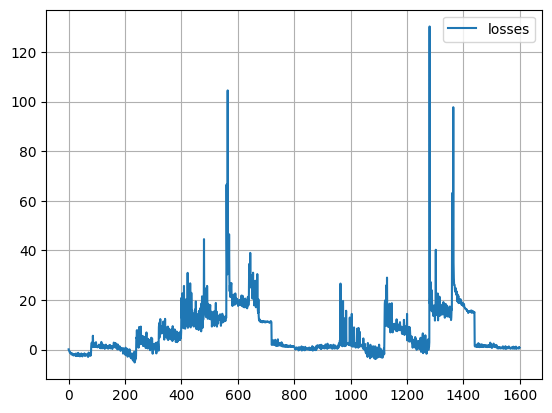

In [455]:
plt.plot(losses, label="losses")
plt.legend()
plt.grid(True)
plt.show()

In [439]:
test_model(actor, pytorch_env(gym.make('HalfCheetah-v5', render_mode='human')))

41.0